In [ ]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [ ]:
user,item,title = 'userId','movieId','title'

In [ ]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/ubuntu/.fastai/data/movie_lens_sample')

In [ ]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [ ]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [ ]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss
1,1.629454,0.982241
2,0.856353,0.678751
3,0.655987,0.669647


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [ ]:
path=Config.data_path()/'ml-100k'

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
len(ratings)

100000

In [ ]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [ ]:
data.show_batch()

userId,title,target
126,Event Horizon (1997),1.0
44,Young Frankenstein (1974),4.0
718,Star Trek: First Contact (1996),4.0
506,"Magnificent Seven, The (1954)",5.0
373,"Good, The Bad and The Ugly, The (1966)",3.0


In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


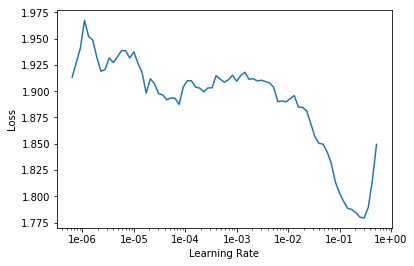

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,0.923900,0.946068
2,0.865458,0.890646
3,0.783896,0.836753
4,0.638374,0.815428
5,0.561979,0.814652


In [ ]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [ ]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3667),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3142),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2926), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2708), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2669), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2641), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2511), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2418), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2345), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2324), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2266), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2219), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2208), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2151), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2089), "Mc

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5913), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5700), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5623), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5412), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5368), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5193), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5149), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5114), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5097), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4946), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4899), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4855), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4769), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4743), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4665), 'Close Shave, A (1995)', 4.491071428571429)]

### Movie weights

In [ ]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2412), 'Home Alone 3 (1997)'),
 (tensor(1.2072), 'Jungle2Jungle (1997)'),
 (tensor(1.2000), 'Bio-Dome (1996)'),
 (tensor(1.1883), 'Leave It to Beaver (1997)'),
 (tensor(1.1570), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.1309), "McHale's Navy (1997)"),
 (tensor(1.1187), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0956), 'Congo (1995)'),
 (tensor(1.0950), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.0524), 'Cutthroat Island (1995)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0692), 'Casablanca (1942)'),
 (tensor(-1.0523), 'Close Shave, A (1995)'),
 (tensor(-1.0142), 'When We Were Kings (1996)'),
 (tensor(-1.0075), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0034), 'Wrong Trousers, The (1993)'),
 (tensor(-0.9905), 'Chinatown (1974)'),
 (tensor(-0.9692), 'Ran (1985)'),
 (tensor(-0.9541), 'Apocalypse Now (1979)'),
 (tensor(-0.9523), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(-0.9369), 'Some Folks Call It a Sling Blade (1993)')]

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8788), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8263), 'Keys to Tulsa (1997)'),
 (tensor(0.8066), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7730), 'Dead Man (1995)'),
 (tensor(0.7513), 'Three Colors: Blue (1993)'),
 (tensor(0.7492), 'Trainspotting (1996)'),
 (tensor(0.7414), 'Cable Guy, The (1996)'),
 (tensor(0.7330), 'Jude (1996)'),
 (tensor(0.7246), 'Clockwork Orange, A (1971)'),
 (tensor(0.7195), 'Stupids, The (1996)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2148), 'Braveheart (1995)'),
 (tensor(-1.1153), 'Titanic (1997)'),
 (tensor(-1.1148), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.8795), "It's a Wonderful Life (1946)"),
 (tensor(-0.8644), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8619), 'Star Wars (1977)'),
 (tensor(-0.8558), 'Return of the Jedi (1983)'),
 (tensor(-0.8526), 'Pretty Woman (1990)'),
 (tensor(-0.8453), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8450), 'Forrest Gump (1994)')]

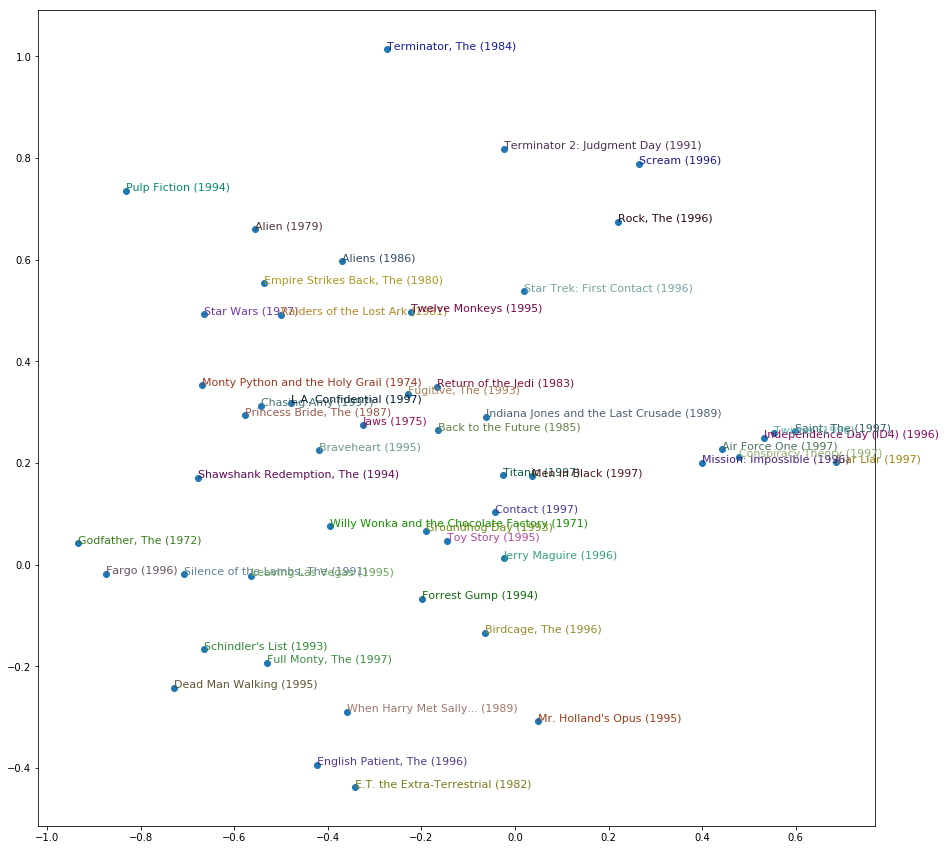

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()